In [1]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from random import seed
from sklearn import preprocessing
seed(1)

In [28]:
class conv_lstm(nn.Module):
    def __init__(self, lr, input_channels = 1, batch_size = 1, lstm_hidden_size = 512, lstm_layer_size = 2):
        super(conv_lstm, self).__init__()
        self.lr = lr
        self.input_channels = input_channels
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #self.height = height
        #self.width = width
        self.batch_size = batch_size
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_layer_size = lstm_layer_size
        self.conv_layer = nn.Conv2d(in_channels = self.input_channels, out_channels = 10,
                                   kernel_size = 3, stride = 1)
        conv_layer_init_ = 1.0/np.sqrt(self.conv_layer.weight.data.size()[0])
        self.conv_layer.weight.data.uniform_(-conv_layer_init_, conv_layer_init_)
        self.conv_layer.bias.data.uniform_(-conv_layer_init_, conv_layer_init_)
        self.conv_layer_batchNorm = nn.BatchNorm2d(10)
        self.pool = nn.MaxPool2d((2,4), stride=1)#experiment with maxpool/avgpool
        #second querry - should i maxpool/avgpool then send to lstm layer or leave it as it is? Refer to paper
        
        #entirely dependant on convlayer out shape
        self.lstm_layer = nn.LSTM(input_size = 5,#check forward shape and last shape: adjust accordingly
                                 hidden_size = self.lstm_hidden_size,
                                 num_layers  = self.lstm_layer_size,
                                 batch_first = True,
                                 dropout = 0.1)
        
        self.fc_layer = nn.Linear(self.lstm_hidden_size, 10)#10 to represebt feature length
        fc_init_ = 1.0/np.sqrt(self.fc_layer.weight.data.size()[0])
        #initialize weights and biases
        self.fc_layer.weight.data.uniform_(-fc_init_, fc_init_)
        self.fc_layer.bias.data.uniform_(-fc_init_, fc_init_)
        
        self.to(self.device)
        
    def forward(self, frames):
        x = self.conv_layer(frames)
        x = self.conv_layer_batchNorm(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.squeeze()
        batch_size = x.size(0)
        hidden_state = torch.zeros(self.lstm_layer_size, 
                                  batch_size,
                                  self.lstm_hidden_size).to(self.device)
        cell_state = torch.zeros(self.lstm_layer_size,
                                batch_size,
                                self.lstm_hidden_size).to(self.device)
        hidden_lstm_layer = (hidden_state, cell_state)
        out, (hn,cn) = self.lstm_layer(x,(hidden_state, cell_state))
        
        #print("lstm_out shape: ", out.shape)
        modified_out = out[:, -1, :]
        fc_out = self.fc_layer(modified_out)
        return fc_out, out, hn

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
def draw_loss_graph(epoch_array, loss_array):
    

In [49]:
def train_model(model, dataloader, optimizer, criterion, epochs=10):
    loss_array = []
    epoch_array = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            #print((inputs.type()))
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print((inputs.type()))
            predictions,_,__ = model(inputs)
            print(predictions.size(), labels.squeeze().size())
            loss_ = criterion(predictions, labels.squeeze())
            loss_.backward()
            optimizer.step()
            
            running_loss += loss_.item()*inputs.size(0) 
        print(running_loss)
        loss_array.append(running_loss/len(dataloader.dataset))
        epoch_array.append(epoch)
    return loss_array, epoch_array

In [87]:
def test_model(model, data_loader, criterion, epochs = 1):
    y_true = []
    y_preds = []
    with torch.no_grad():
        for epoch in range(epochs):
                running_loss = 0.0
                for inputs, labels in data_loader:
                    inputs = inputs.type(torch.FloatTensor)
                    labels = labels.type(torch.FloatTensor)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs,_,__ = model(inputs)
                    #print("labels: ", labels.shape)
                    #print("outputs: ", outputs.shape)
                    loss = criterion(outputs, labels.squeeze())
                                            
                    running_loss+=loss.item()*inputs.size(0)                    
                    #print("preds: ", preds, " targets: ", targets)
                    #print(y_true.shape)
                    labels = labels.squeeze()
                    y_true.append(labels.detach().cpu().numpy())
                    y_preds.append(outputs.detach().cpu().numpy())
                    
                print("epoch: ",epoch)
                print("loss: ",running_loss/len(data_loader.dataset))
    return y_true, y_preds

In [31]:
model = conv_lstm(lr = 0.001)

In [32]:
model

conv_lstm(
  (conv_layer): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv_layer_batchNorm): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 4), stride=1, padding=0, dilation=1, ceil_mode=False)
  (lstm_layer): LSTM(5, 512, num_layers=2, batch_first=True, dropout=0.1)
  (fc_layer): Linear(in_features=512, out_features=10, bias=True)
)

In [7]:
tensor_ = torch.rand(10, 10)

In [8]:
tensor_.shape#B,C,H,W

torch.Size([10, 10])

In [11]:
tensor_ = tensor_.unsqueeze(dim = 0)

In [12]:
out_, _,__= model(tensor_.to("cpu"))
out_.shape

torch.Size([10, 10])

In [7]:
#Implement dataloader
from torch.utils.data import DataLoader

In [24]:
#how do i wanna load data?
#input: frame one
#output(label): frame 2
import ipynb.fs.full.Flood_dataloader as Flood_dataloader
import os
#file_       = 'conv_lstm.csv'
file_       = os.path.join("csv_files/", "convlstm.csv")
root_input  = 'frame_tensors/'
root_output = 'frame_output_tensors/'
dataset = Flood_dataloader.conv_lstm_dataloader(file_, root_input, root_output)
len(dataset)

78

In [41]:
split_x = 48
split_y = 30
#split_x = 191
#split_y = 5
batch_size = 1
train_set, test_set = torch.utils.data.random_split(dataset,[split_x,split_y])
train_loader = DataLoader(dataset=train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset=test_set, batch_size = batch_size, shuffle = False)

In [33]:
criterion = torch.nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
x_values, y_values = train_model(model, train_loader, optimizer, criterion, epochs=10)

torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])
torch.Size([10, 10]) torch.Size([10, 10])


KeyboardInterrupt: 

In [37]:
import seaborn as sns
import pandas as pd
data1 = {'loss':x_values,'epoch':y_values}
df1 = pd.DataFrame(data1)
df1.head()

,loss,epoch
0,0.103654,0
1,0.065112,1
2,0.049086,2
3,0.037397,3
4,0.031930,4


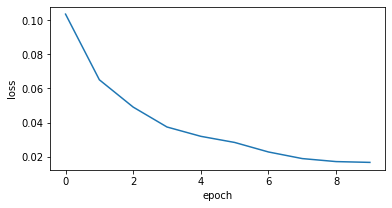

In [38]:
plt.rcParams["figure.figsize"] = (6,3) #set plot size
plt3 = sns.lineplot(x="epoch", y="loss", data=df1) #blue

In [59]:
tr,pr = test_model(model, test_loader, criterion, epochs = 1)

labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 10])
labels:  torch.Size([1, 1, 10, 10])
outputs:  torch.Size([10, 

In [76]:
import sklearn.preprocessing as scaler

In [80]:
tr_np = np.array(tr)
pr_np = np.array(pr)

In [81]:
for data in range(len(tr_np)):
    norm_ = scaler.minmax_scale(tr_np[data],feature_range=(0,255))
    tr_np[data] = norm_

In [82]:
for data in range(len(pr_np)):
    norm_ = scaler.minmax_scale(pr_np[data],feature_range=(0,255))
    pr_np[data] = norm_

In [83]:
tr_np = np.expand_dims(tr_np, axis=1)
pr_np = np.expand_dims(pr_np, axis=1)
print(tr_np.shape, pr_np.shape)

(30, 1, 10, 10) (30, 1, 10, 10)


In [84]:
tr_np = tr_np.transpose(0,2,3,1)
pr_np = pr_np.transpose(0,2,3,1)
print(tr_np.shape, pr_np.shape)

(30, 10, 10, 1) (30, 10, 10, 1)


In [85]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(list(tr_np), fps=3)
clip.write_gif('true_data.gif', fps=3)

MoviePy - Building file true_data.gif with imageio.


In [86]:
from moviepy.editor import ImageSequenceClip
clip = ImageSequenceClip(list(pr_np), fps=3)
clip.write_gif('preicted_data.gif', fps=3)

MoviePy - Building file preicted_data.gif with imageio.


In [62]:
pr[1]

array([[ 1.07673538e+00,  9.85126495e-02,  8.97179842e-01,
         1.08610487e+00,  5.81517816e-03,  5.22624850e-02,
         1.86553076e-02,  8.00375417e-02,  3.18029374e-02,
         2.36323833e-01],
       [ 9.69692618e-02,  3.60730886e-01,  7.84743607e-01,
         2.37492472e-01,  7.18802214e-01,  1.60193935e-01,
         6.97658733e-02,  2.89516240e-01,  4.95440587e-02,
         2.00459883e-01],
       [ 3.08258869e-02,  4.41867769e-01,  2.98427820e-01,
         7.23619401e-01,  1.65910035e-01,  4.63694036e-02,
         1.07002474e-01,  5.74903078e-02,  1.71947777e-02,
         6.26910180e-02],
       [ 1.14961350e+00,  1.25950122e+00,  1.06955540e+00,
         1.25855505e-01,  8.43452066e-02,  1.06693590e+00,
         1.37317702e-01, -1.14614181e-01,  1.20636475e+00,
         1.14666462e+00],
       [ 7.04396218e-02,  2.41696164e-01,  3.31563652e-01,
         1.77774653e-01,  2.05930263e-01,  4.48351949e-02,
         1.76013172e-01,  2.35307410e-01,  1.80200264e-02,
         7.

In [67]:
import sklearn.preprocessing as scaler
#scaler.minmax_scale(pr[1].squeeze(),feature_range=(0,255))

In [16]:
import pandas as pd
fgds = pd.read_csv(file_)

In [17]:
fgds

,Unnamed: 0,Inputs,Labels
0,0,0.pt,0.pt
1,1,1.pt,1.pt
2,2,2.pt,2.pt
3,3,3.pt,3.pt
4,4,4.pt,4.pt
...,...,...,...
73,73,73.pt,73.pt
74,74,74.pt,74.pt
75,75,75.pt,75.pt
76,76,76.pt,76.pt
